In [1]:
import datetime

import numpy             as np
import matplotlib.pyplot as plt

from CCfun  import in_range
from CCfun  import filter_df
from CCfun  import longer_than_exwl
from CCfun  import find_crystal_position
from CCfun  import compute_baseline_between

from CCfit  import fit
from CCfit  import polynom
from CCfit  import gauss
from CCfit  import double_gauss

from CCplot import auto_plot_style
from CCplot import plot1d
from CCplot import plot2d

from CCio import load_and_process

In [2]:
%matplotlib inline

auto_plot_style({"lines.linewidth": 2, "font.size":20})

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
SPIKES_THRESHOLD = 150

def remove_spikes(data):
    diff    = np.append([0], np.diff(data.counts))
    ok      = diff < SPIKES_THRESHOLD
    counts  = data.counts .where(ok, np.nan)
    bkgsub  = data.bkgsub .where(ok, np.nan)
    rate    = data.rate   .where(ok, np.nan)
    dquanta = data.dquanta.where(ok, np.nan)
    return data.assign(counts  = counts .fillna(method="ffill"),
                       bkgsub  = bkgsub .fillna(method="ffill"),
                       rate    = rate   .fillna(method="ffill"),
                       dquanta = dquanta.fillna(method="ffill"))

def calculate_irradiation_times(dates):
    dates = np.asarray(dates[1:])
    dates = dates.reshape(dates.size // 2, 2)
    return [t[0].total_seconds() / 3600 for t in np.diff(dates, axis=1)]

In [5]:
def double_gauss_poly(x, *args):
    gauss1 = args[0:3]
    gauss2 = args[3:6]
    poly   = args[6: ]
    return double_gauss(x, *gauss1, *gauss2) + polynom(x, *poly)

def triple_gauss_poly(x, *args):
    gauss1 = args[0:3]
    gauss2 = args[3:6]
    gauss3 = args[6:9]
    poly   = args[9: ]
    return double_gauss(x, *gauss1, *gauss2) + gauss(x, *gauss3) + polynom(x, *poly)

def load(filename, i=0):
    full_df = load_and_process(filename, i).crystals.groupby("state", as_index=False)\
                                           .apply(remove_spikes)\
                                           .reset_index(drop=True)
    return filter_df(full_df, crystal=4, grating=2, exposure=10, ex_wl=440)

# All data

In [6]:
filename_pre1   = "/home/gonzalo/data/CC/cs137_irrad_v1_2020_05_15_22_36_27_269000.h5"
filename_post11 = "/home/gonzalo/data/CC/cs137_irrad_lif_440_2020_05_17_03_17_44_873000.h5"
filename_post12 = "/home/gonzalo/data/CC/cs137_irrad_lif_440_2020_05_17_13_13_21_743000.h5"
filename_pre2   = "/home/gonzalo/data/CC/cs137_irrad_v1_2020_05_18_18_36_27_229800.h5"
filename_post21 = "/home/gonzalo/data/CC/cs137_irrad_lif_440_2020_05_19_01_19_12_522000.h5"
filename_post22 = "/home/gonzalo/data/CC/cs137_irrad_lif_440_2020_05_20_01_30_06_881000.h5"
filename_pre3   = "/home/gonzalo/data/CC/cs137_irrad_v1_2020_05_21_22_48_52_962000.h5"
filename_post31 = "/home/gonzalo/data/CC/cs137_irrad_lif_440_2020_05_22_16_00_41_444000.h5"
filename_post32 = "/home/gonzalo/data/CC/cs137_irrad_lif_440_2020_05_23_14_18_19_136000.h5"
filename_post33 = "/home/gonzalo/data/CC/cs137_irrad_lif_440_2020_05_24_04_02_26_715000.h5"

filename_bleach = "/home/gonzalo/data/CC/cs137_irrad_lif_440_2020_05_24_12_42_20_662000.h5"

pre1   = load(filename_pre1  )
post11 = load(filename_post11)
post12 = load(filename_post12)

pre2   = load(filename_pre2  )
post21 = load(filename_post21)
post22 = load(filename_post22)

pre3   = load(filename_pre3  )
post31 = load(filename_post31)
post32 = load(filename_post32)
post33 = load(filename_post33)

bleach = load(filename_bleach)

# Pres

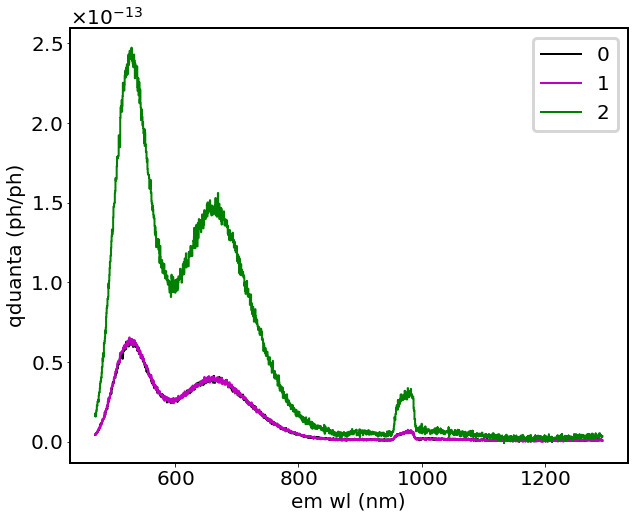

In [7]:
for i, pre in enumerate((pre1, pre2, pre3)):
    plt.plot(pre.em_wl, pre.dquanta, drawstyle="steps", label=str(i))
plt.xlabel("em wl (nm)")
plt.ylabel("qduanta (ph/ph)")
plt.legend();

In [8]:
times      = {}
fit_values = {}

msets = ((pre1, post11, post12),
         (pre2, post21, post22),
         (pre3, post31, post32, post33),
         (bleach,))
for im, mset in enumerate(msets, start=1):
    t0     = mset[0].timestamp.iloc[0]
    ts     = []
    fit_vs = []

    for m in mset:
        for _, df in m.groupby("state"):
            data = df[~in_range(df.em_wl, 930, 1000)]
            low  = 1e-16, 500, 20,    1e-16, 600, 40,       0 
            seed = 1e-12, 525, 30,    1e-12, 650, 65,       1e-16
            upp  = 1e-10, 550, 50,    1e-10, 675, 80,       1e-15 

            f    = fit(double_gauss_poly, data.em_wl.values, data.dquanta.values,
                       seed      = seed,
                       maxfev    = 10**5)

            ts    .append((df.timestamp.iloc[0] - t0).total_seconds())
            fit_vs.append(f.values)

    times     [im] = np.array(ts) / 3600
    fit_values[im] = np.stack(fit_vs).T

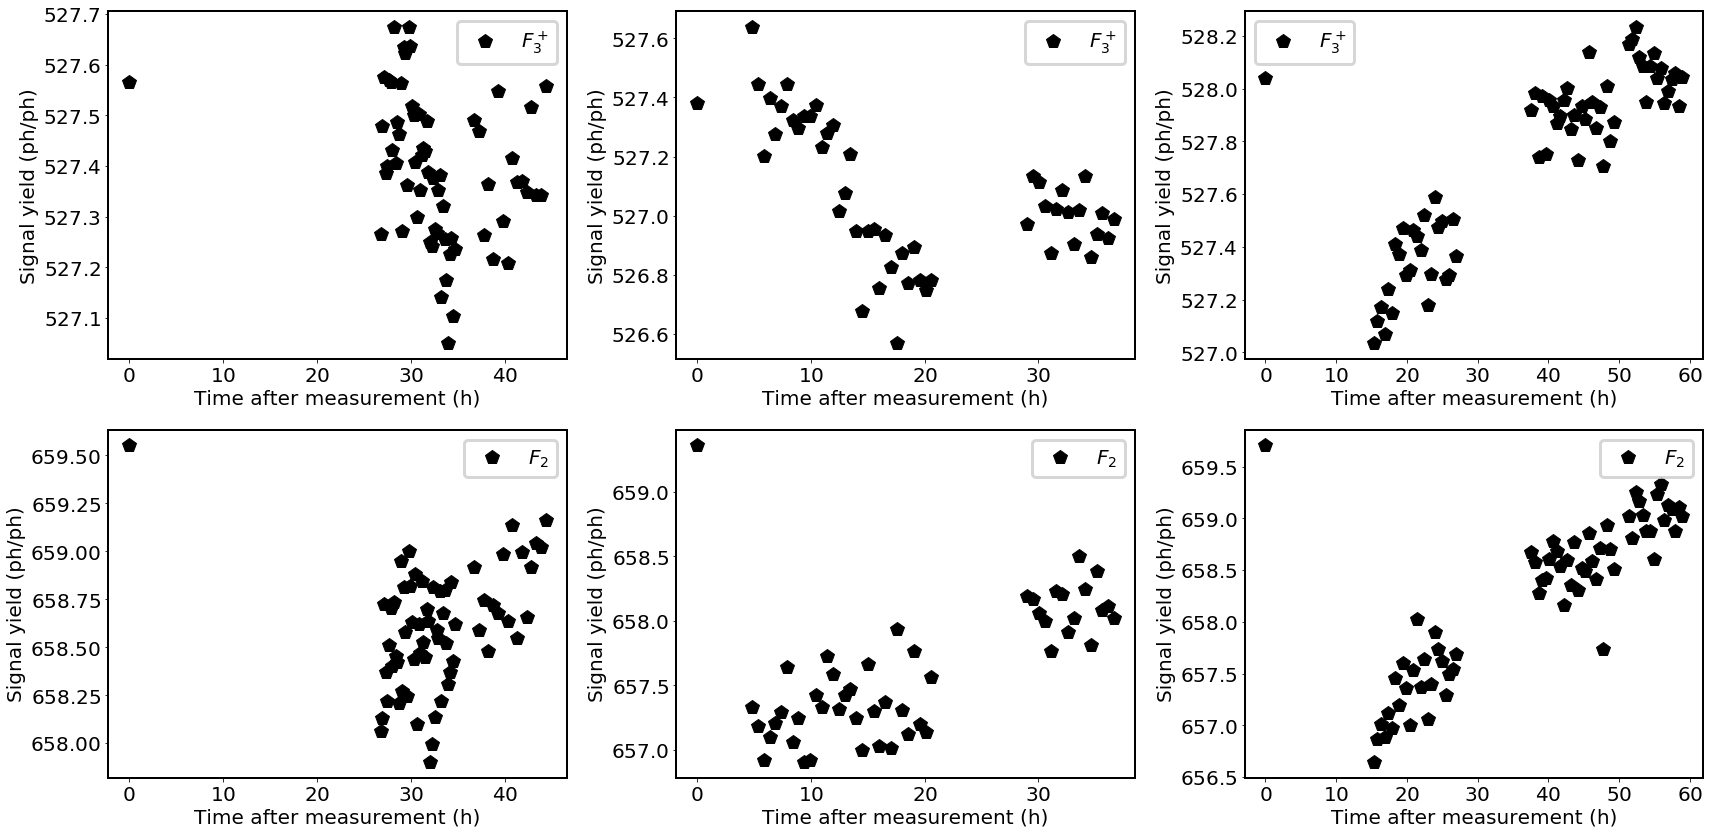

In [10]:
plt.figure(figsize=(24, 12))

for im in sorted(times)[:-1]:
    plt.subplot(2, 3, im)
    plt.plot(times[im], fit_values[im][1], "p", label=f"$F_3^+$")
    plt.xlabel("Time after measurement (h)")
    plt.ylabel("Signal yield (ph/ph)")
    plt.legend()

    plt.subplot(2, 3, im+3)
    plt.plot(times[im], fit_values[im][4], "p", label=f"$F_2$")
    plt.xlabel("Time after measurement (h)")
    plt.ylabel("Signal yield (ph/ph)")
    plt.legend()

plt.tight_layout()

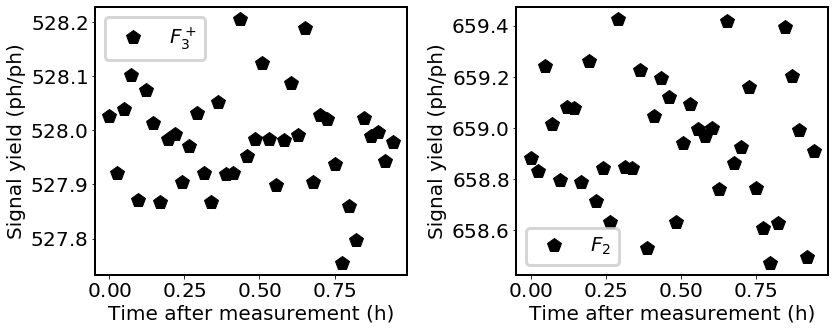

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(times[4], fit_values[4][1], "p", label=f"$F_3^+$")
plt.xlabel("Time after measurement (h)")
plt.ylabel("Signal yield (ph/ph)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(times[4], fit_values[4][4], "p", label=f"$F_2$")
plt.xlabel("Time after measurement (h)")
plt.ylabel("Signal yield (ph/ph)")
plt.legend()

plt.tight_layout()